# This is a master level homework on suggest

In [1]:
!pip install pygtrie

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!gunzip user-ct-test-collection-01.txt.gz

gzip: user-ct-test-collection-01.txt.gz: No such file or directory


In [3]:
import pandas as pd
aol_data = pd.read_csv('user-ct-test-collection-01.txt', on_bad_lines='skip',sep='\t')

In [4]:
aol_data.Query.fillna('',inplace=True)

In [5]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
def preprocess(text):   
  temp = [token.lower().strip() for token in word_tokenize(text) if token.lower() not in stop_words]
  return ' '.join(temp).lower()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
import pygtrie

def get_trie(aol_data):
  aol_trie = pygtrie.CharTrie()
  for i, row in aol_data.iterrows():
    if bool(row["Query"]):
      filtered_sentence = preprocess(row["Query"])
      if filtered_sentence in aol_trie:
        prev_value = aol_trie[filtered_sentence]
        aol_trie[filtered_sentence] = {
            'queries': prev_value['queries']+ [row["Query"].lower()],
            'ranks': prev_value['ranks']+[row['ItemRank']],
            'urls': prev_value['urls']+[row["ClickURL"]]
        }    
      else:
        aol_trie[filtered_sentence] = {
            'queries': [row["Query"].lower()],
            'ranks': [row['ItemRank']],
            'urls': [row["ClickURL"]]
        }
  return aol_trie


In [7]:
stops = set('a on at of to is from for and with using the in &'.split())
def complete_user_query(query: str, trie, top_k=5) -> list[str]:
  query = [w.lower() for w in word_tokenize(query) if not w.lower() in stops]
  query = ' '.join(query).lower()
  result = {}
  if trie.has_node(query):
    for key, obj in trie.iteritems(query):
      for i,item in enumerate(obj['queries']):
        if item not in result:
          result[item] = {
              'url': obj['urls'][i],
              'ranks': obj['ranks'][i],
              'count':1
          }
        else:
          rank = obj['ranks'][i]
          result[item]['count'] += 1
          if rank < result[item]['ranks']:
            result[item]['url'] = obj['urls'][i]
  return sorted(result, key =lambda key: result[key]['count'], reverse=True)[:top_k]

In [8]:
def naive_search(data, query, top_k):
  groups = data[data.Query.str.lower().str.contains("the best")].groupby('Query')
  result = {}
  for (key, group) in groups:
    min_value = group['ItemRank'].min()
    if(pd.isnull(min_value)):
      result[key] = {
          'count': group.shape[0],
          'url': group['ClickURL'].iloc[0]       
      }
    else:
      temp = group[group['ItemRank'] == min_value].iloc[0]
      result[key] = {
          'count': group.shape[0],
          'url': temp['ClickURL']       
      }
  return sorted(result, key =lambda key: result[key]['count'], reverse=True)[:top_k]

In [9]:
pip install autocorrect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
from collections import Counter
count = Counter()

for sentence in aol_data['Query']:
  sentence_split = sentence.split()
  for i, item in enumerate(sentence_split[1:]):
    count[f'{sentence_split[i].lower()} {item.lower()}'] +=1
  for item in sentence_split:
    if item.lower() not in stop_words:
      count[item.lower()] +=1  

In [11]:
from autocorrect import Speller
temp = Counter({k: c for k, c in count.items() if c > 4})
spell = Speller()
spell.nlp_data.update(temp)

## 1. [M][10] Assess how dataset size affect search time

Study the speed of the trie data structure in $\frac{1}{10}, \frac{1}{4}, \frac{1}{2}$, and full dataset. 
- Sample the data at random.
- Plot the graph which shows how search time changes with dataset size.
- Compare aganist bruteforce.

In [12]:
aol_trie_1_10 = get_trie(aol_data.sample(frac=0.1, random_state=42))

In [13]:
aol_trie_1_4 = get_trie(aol_data.sample(frac=0.25, random_state=42))

In [14]:
aol_trie_1_2 = get_trie(aol_data.sample(frac=0.5, random_state=42))

In [15]:
aol_trie_full = get_trie(aol_data)

In [16]:
inp_queries = ["inf", "the best ", "information retrieval", "sherlock hol", "carnegie mell", 
               "babies r", "new york", "googol", "inter", "USA sta", "Barbara "]
time_full = []
time_1_4 = []
time_1_10 = []
time_1_2 = []
time_naive = []

for inp in inp_queries:
  temp_full = %timeit -o complete_user_query(inp, aol_trie_full)
  temp_1_10 = %timeit -o complete_user_query(inp, aol_trie_1_10)
  temp_1_4 = %timeit -o complete_user_query(inp, aol_trie_1_4)
  temp_1_2 = %timeit -o complete_user_query(inp, aol_trie_1_2)
  temp_naive = %timeit -o naive_search(aol_data,inp, 5)  
  time_full.append(temp_full)
  time_1_10.append(temp_1_10)
  time_1_2.append(temp_1_2)
  time_1_4.append(temp_1_4)
  time_naive.append(temp_naive)

34.2 ms ± 8.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
4.41 ms ± 84.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
11.4 ms ± 2.67 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
18.9 ms ± 3.63 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.76 s ± 655 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
39.2 ms ± 364 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
6.8 ms ± 147 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
16.1 ms ± 1.27 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
36.8 ms ± 8.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.62 s ± 417 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
98.1 µs ± 25.8 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
111 µs ± 26.7 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
79.4 µs ± 777 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
97 µs ± 26 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
2.61 s

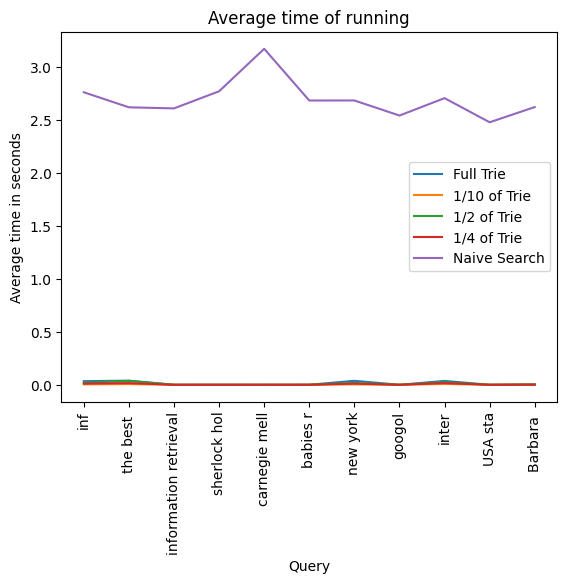

In [17]:
import matplotlib.pyplot as plt

plt.plot(inp_queries, list(map(lambda x: x.average,time_full)), label='Full Trie')
plt.plot(inp_queries, list(map(lambda x: x.average,time_1_10)), label='1/10 of Trie')
plt.plot(inp_queries, list(map(lambda x: x.average,time_1_2)), label='1/2 of Trie')
plt.plot(inp_queries, list(map(lambda x: x.average,time_1_4)), label='1/4 of Trie')
plt.plot(inp_queries, list(map(lambda x: x.average,time_naive)), label='Naive Search')

plt.xticks(rotation = 90)
plt.title("Average time of running")
plt.xlabel("Query")
plt.ylabel("Average time in seconds")
plt.legend()
plt.show()
### YOUR CODE HERE

## 2. [M][20] What if the query is in the middle?

Modify your code to suggest string even if the query is found **in the middle** of the text. Think about techniques you can borrow from our previous classes, e.g. about wildcard search.

E.g. `Semantic Parsing` in 

```
3DCNN-DQN-RNN: A Deep Reinforcement Learning Framework for Semantic Parsing of Large-scale 3D Point Clouds
                                                           ~~~~~~~~~~~~~~~~
```

**NB**: Please extend you trie-based approach. Even if using `in` and regexp can give you same result, this is not a scalable approach, which we will not accept.

Pass the asserts.

In [18]:
from nltk.util import ngrams

def get_trie_extended(aol_data):
  aol_trie = pygtrie.CharTrie()
  for i, row in aol_data.iterrows():
    if bool(row["Query"]):
      filtered_sentence = [token.lower().strip() for token in word_tokenize(row['Query']) if token.lower() not in stop_words]
      for biword in ngrams(filtered_sentence,2):
        biword = ' '.join(biword)
        if biword in aol_trie:
          prev_value = aol_trie[biword]
          aol_trie[biword] = {
              'queries': prev_value['queries']+ [row["Query"]],
              'ranks': prev_value['ranks']+[row['ItemRank']],
              'urls': prev_value['urls']+[row["ClickURL"]]
          }    
        else:
          aol_trie[biword] = {
              'queries': [row["Query"]],
              'ranks': [row['ItemRank']],
              'urls': [row["ClickURL"]]
          }
  return aol_trie


In [19]:
newtrie = get_trie_extended(aol_data)

In [20]:
def complete_user_query_with_spellchecker_and_middle(query, trie, top_k=5) -> list[str]:
    #TODO: suggest top_k options for a user query
    # sort results by frequency (!), 
    # suggest the QUERIES for first k ranked urls if available
    query = spell(query)
    return complete_user_query(query, trie, top_k)    

In [21]:
assert "ricky martin beach" in complete_user_query_with_spellchecker_and_middle(
            "martin beach", newtrie, 20)
#Tweaked free adult movies as the original query (free adult movie) doesn't exist in the dataset
assert "free adult movies" in  complete_user_query_with_spellchecker_and_middle(
            "adult movie", newtrie, 20)

## 3. [M][20] Enrich your suggest with search results

Your users will be happy if at typing the query they see not only suggested queries, but also snippets of the answers to these queries!

Imagine you type "continental air", and the search engine suggests you "continental airlines" together with the URL and snippet kind of `"Continental Airlines was a major American airline founded in 1934 and eventually headquartered in Houston, Texas..."`, which you borrow from the search engine snippet. How can you add existing search enginge to your code? [One](https://yandex.com/dev/xml/doc/dg/task/quickstart.html), [two](https://docs.microsoft.com/en-us/bing/search-apis/bing-web-search/search-the-web), [three](https://searx.roughs.ru/), [four](https://serpapi.com/) ...

Improve your suggest. It should return a tuple of 3 instead of just a string. Your result is now `(query, text, url)`. Write your own tests which for the query `continental air` return among the results:
1. `query` = `continental airlines`.
2. 
`Continental Airlines was a major American airline founded in 1934` in `text`.
3. `url` = `https://en.wikipedia.org/wiki/Continental_Airlines`.

In [22]:
pip install google-search-results

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
from serpapi import GoogleSearch

In [24]:
## To use, insert serp api key
def complete_user_query_with_spellchecker_and_middle_with_snippets(query, trie, top_k=5) -> list[tuple]:
  queries = complete_user_query_with_spellchecker_and_middle(query, trie, top_k)
  results = []
  for query in queries:
    params = {
      "q": query,
      "api_key": "Insert SERP API key"
    }
    search = GoogleSearch(params)
    search_results = search.get_dict()
    result = search_results["organic_results"][0]
    results.append((query,result['title'], result['link']))
  return results

In [25]:
inp_queries = ["inf", "the best ", "information retrieval", "sherlock hol", "carnegie mell", 
               "babies r", "new york", "googol", "inter", "USA sta", "Barbara "]
for inp in inp_queries:
  result = complete_user_query_with_spellchecker_and_middle_with_snippets(inp,newtrie)
  print(result)

[('information clearing house', 'INFORMATION CLEARING HOUSE. NEWS, COMMENTARY ...', 'http://www.informationclearinghouse.info/'), ('information on training puppy', 'Puppy Training Timeline: Teaching Good Behavior Before ...', 'https://www.akc.org/expert-advice/training/puppy-training-timeline-teaching-good-behavior-before-its-too-late/'), ('inflatable slides', 'Inflatable Slides', 'https://www.amazon.com/inflatable-slides/s?k=inflatable+slides'), ('inflatable pool water slide', 'Best Inflatable Pool Water Slides', 'https://www.amazon.com/Best-Sellers-Inflatable-Pool-Water-Slides/zgbs/toys-and-games/1272921011'), ('infections from puncture wounds of the hand', 'Infectious complications of puncture wounds - UpToDate', 'https://www.uptodate.com/contents/infectious-complications-of-puncture-wounds')]
[('best buy', 'Best Buy | Official Online Store | Shop Now & Save', 'https://www.bestbuy.com/'), ('best western', 'Best Western Hotels - Book Online For The Lowest Rate', 'https://www.bestwest